# CGAN

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                    Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

In [3]:
def build_generator(z_dim):
    model = Sequential()
    
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    return model

In [4]:
def build_cgan_generator(z_dim):
    model = Sequential()
    
    z = Input(shape=(z_dim, ))
    
    label = Input(shape=(1, ), dtype='int32')
    
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    
    joined_representation = Multiply()([z, label_embedding])
    
    generator = build_generator(z_dim)
    
    conditioned_img = generator(joined_representation)
    
    return Model([z, label], conditioned_img)

In [5]:
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [6]:
def build_cgan_discriminator(img_shape):
    img = Input(shape=img_shape)
    label = Input(shape=(1, ), dtype='int32')
    
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    discriminator = build_discriminator(img_shape)
    
    classification = discriminator(concatenated)
    
    return Model([img, label], classification)

In [7]:
def build_cgan(genreator, discriminator):
    z = Input(shape=(z_dim, ))
    
    label = Input(shape=(1, ))
    
    img = generator([z, label])
    
    classification = discriminator([img, label])
    
    model = Model([z, label], classification)
    return model

In [8]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

generator = build_cgan_generator(z_dim)

discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [9]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = x_train / 127.5 - 1.
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs, labels = x_train[idx], y_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])
        
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        
        g_loss = cgan.train_on_batch([z, labels], real)
        
        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
            
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])
            
            sample_images()

In [10]:
def sample_images(image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    f, ax = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            ax[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            ax[i, j].axis('off')
            ax[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

1000 [D loss: 0.625598, acc.: 50.00%] [G loss: 0.872444]
2000 [D loss: 0.735779, acc.: 0.00%] [G loss: 0.665326]
3000 [D loss: 0.718729, acc.: 28.12%] [G loss: 0.617765]
4000 [D loss: 0.698839, acc.: 65.62%] [G loss: 0.664389]
5000 [D loss: 0.712662, acc.: 31.25%] [G loss: 0.630135]
6000 [D loss: 0.695817, acc.: 39.06%] [G loss: 0.659833]
7000 [D loss: 0.691413, acc.: 35.94%] [G loss: 0.672737]
8000 [D loss: 0.660150, acc.: 62.50%] [G loss: 0.712904]
9000 [D loss: 0.684551, acc.: 57.81%] [G loss: 0.727920]
10000 [D loss: 0.582753, acc.: 100.00%] [G loss: 0.699070]
11000 [D loss: 0.576932, acc.: 100.00%] [G loss: 0.741898]
12000 [D loss: 0.638246, acc.: 87.50%] [G loss: 0.682475]
13000 [D loss: 0.640880, acc.: 78.12%] [G loss: 0.709680]
14000 [D loss: 0.587545, acc.: 92.19%] [G loss: 0.693708]
15000 [D loss: 0.514598, acc.: 93.75%] [G loss: 0.795084]
16000 [D loss: 0.556813, acc.: 87.50%] [G loss: 0.897193]
17000 [D loss: 0.424997, acc.: 93.75%] [G loss: 0.872125]
18000 [D loss: 0.46266

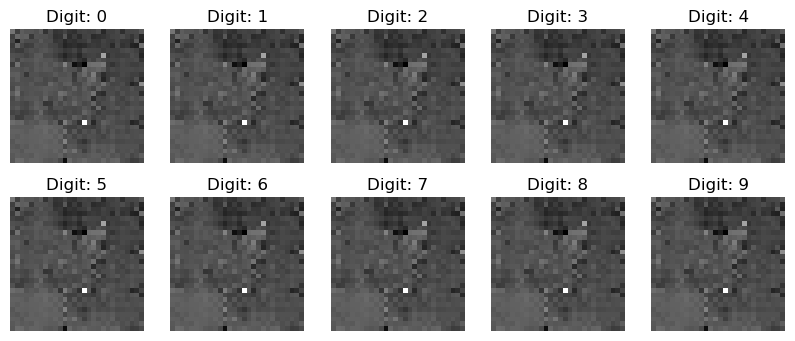

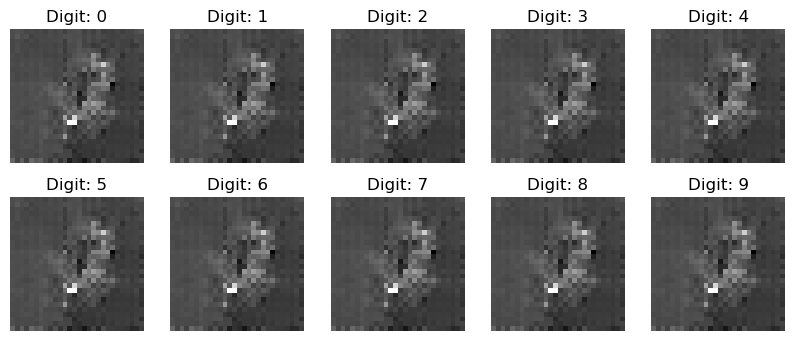

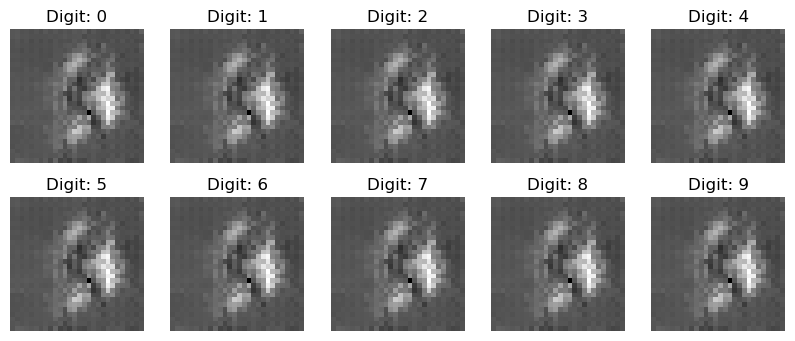

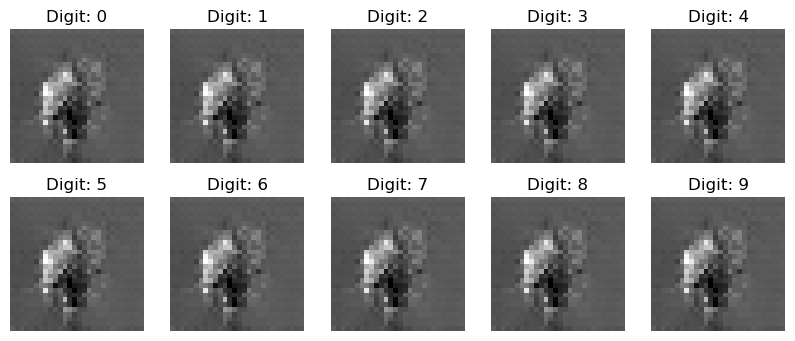

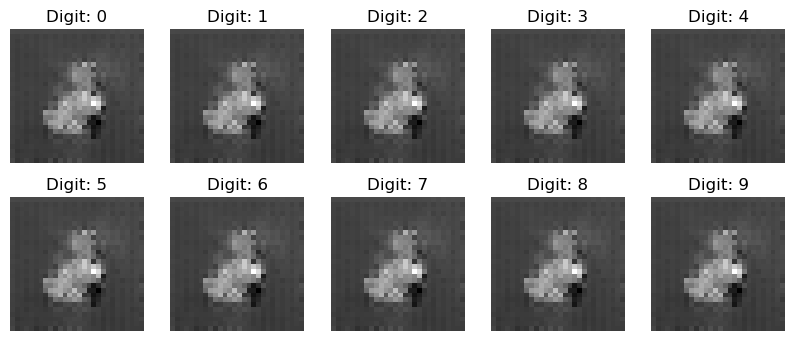

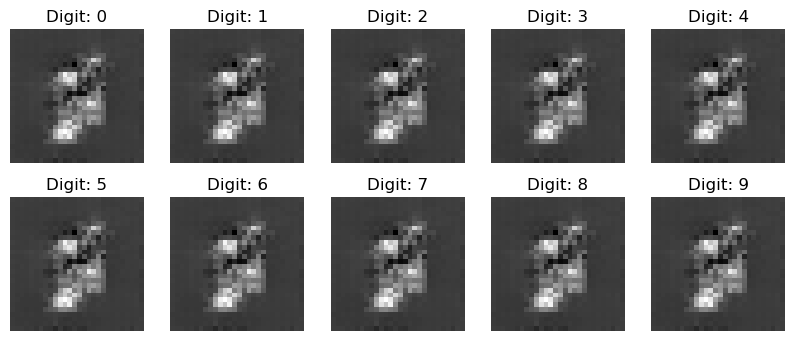

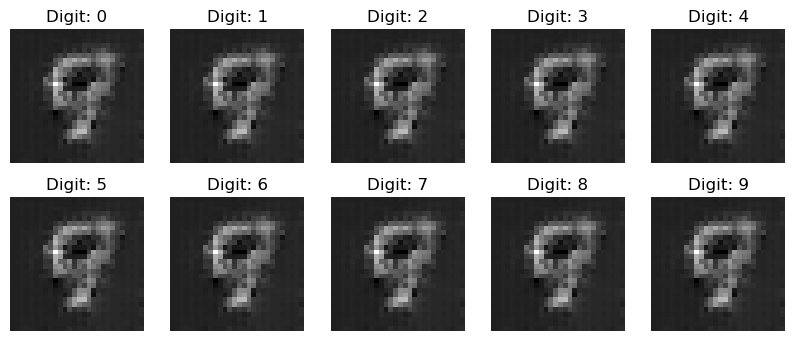

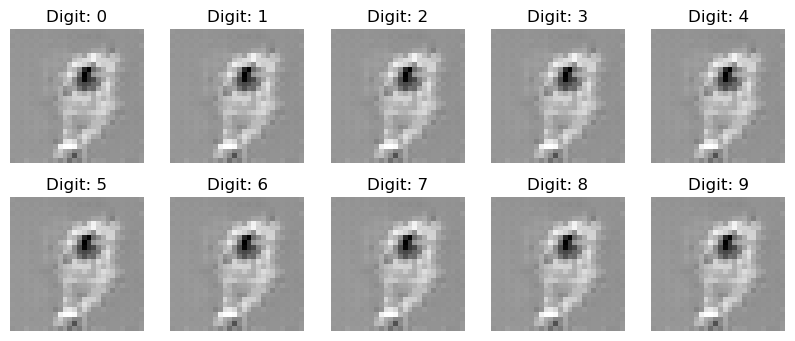

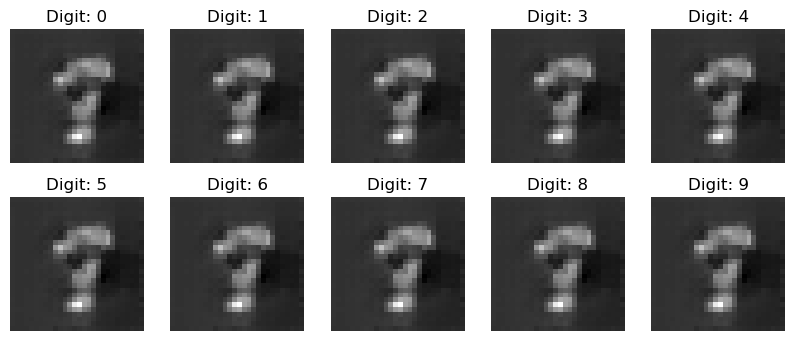

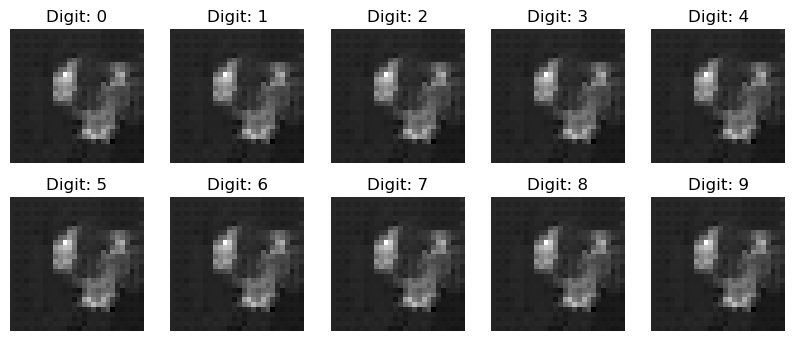

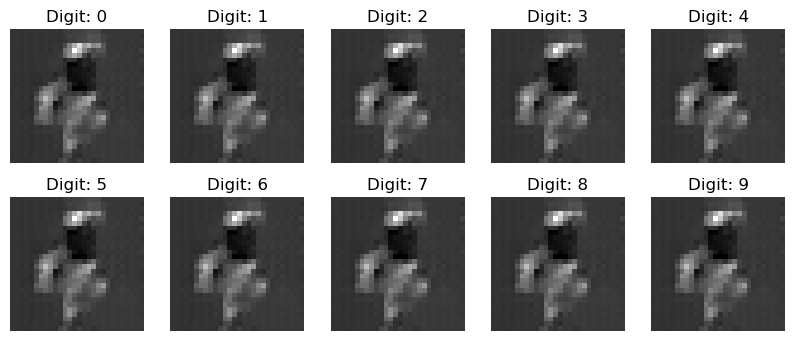

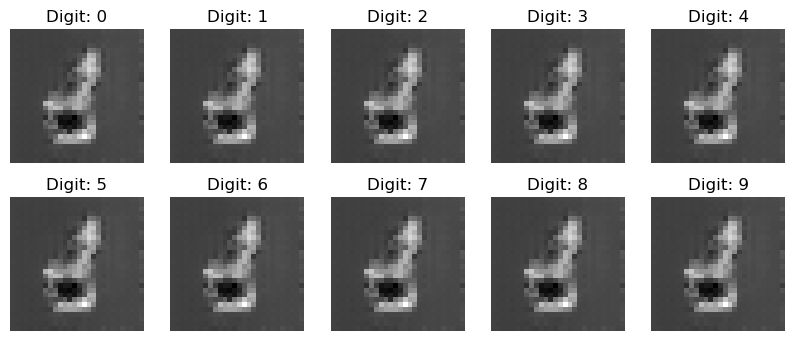

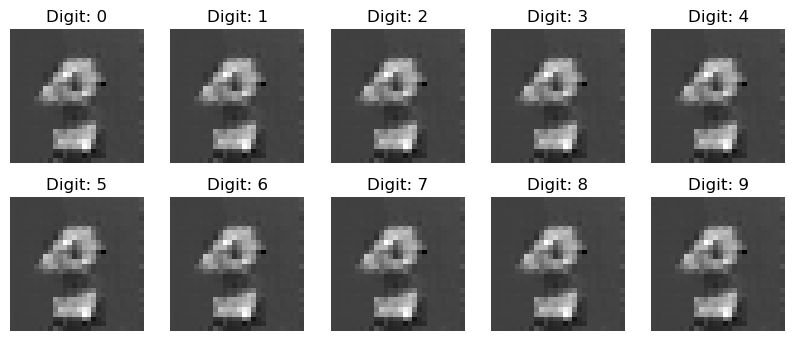

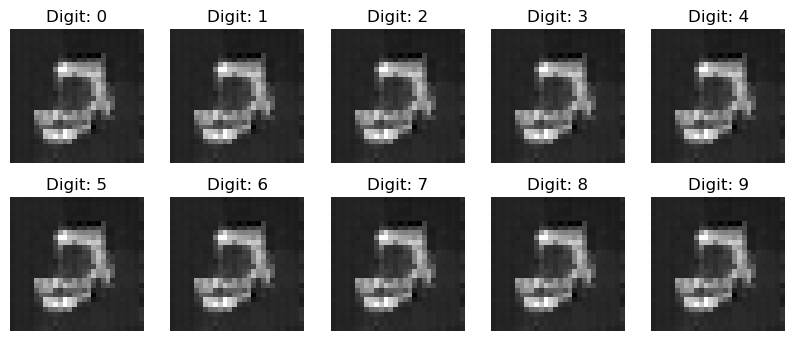

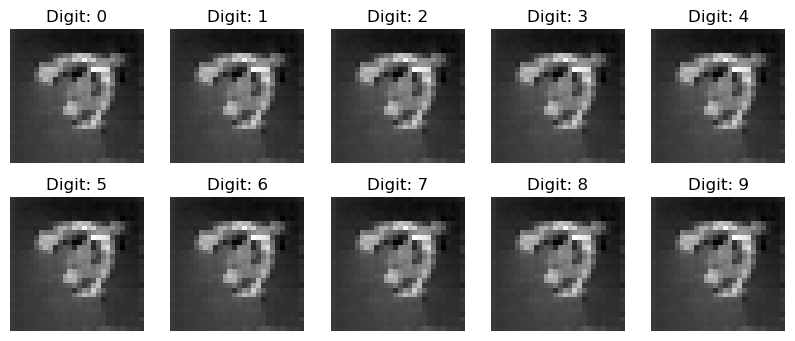

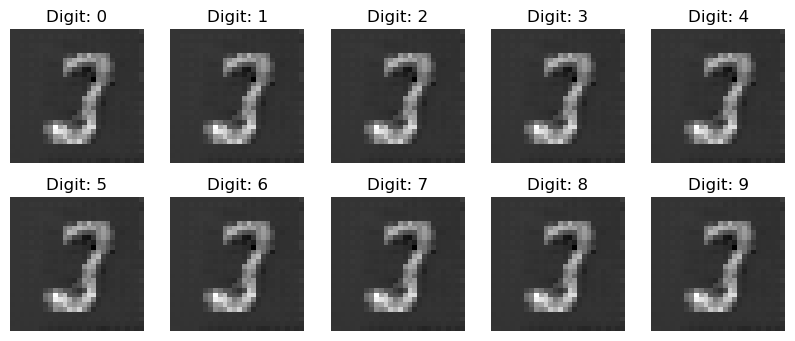

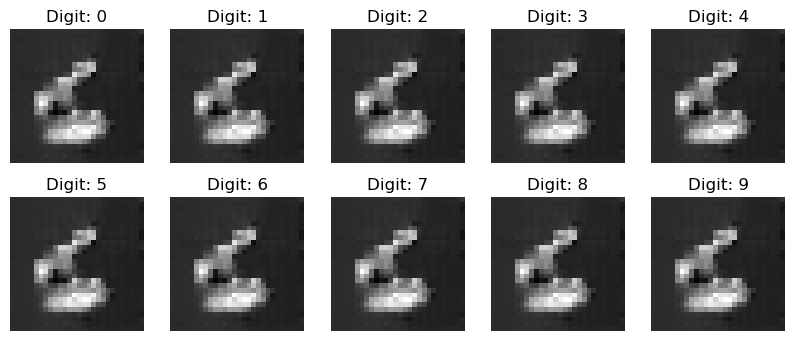

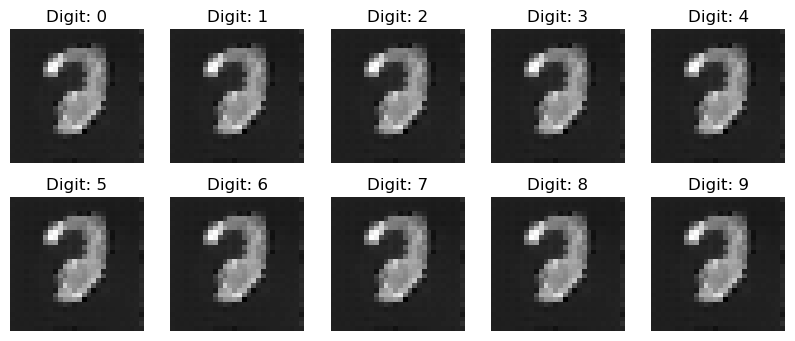

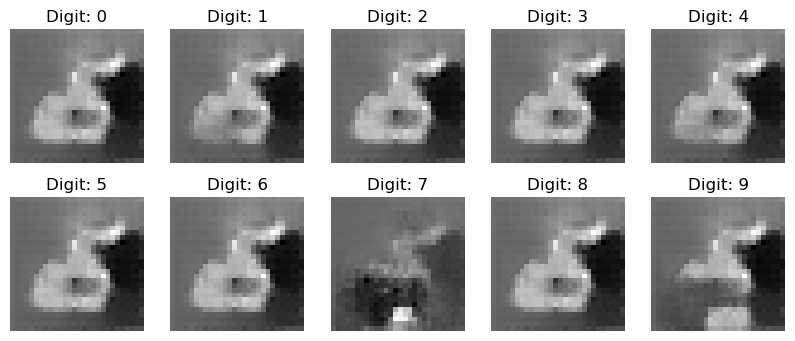

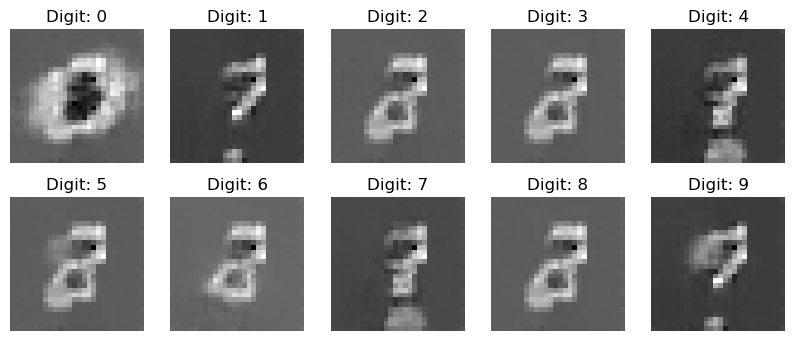

In [11]:
iterations = 20000
batch_size=32
sample_interval = 1000

train(iterations, batch_size, sample_interval)